Use this document as an example document for RamanLib.
- [ ] Visualising the effect of preprocessing steps on data

## Next Steps:

Preprocessing:
- Implement automatic substrate removal:
  - https://pubs.rsc.org/en/content/articlelanding/2009/an/b821856k
  - https://doi.org/10.1016%2Fj.forsciint.2013.04.033
- And substrate removal for heterogenous substrate (multivariate curve resolution) (e.g. in forensic analysis)
  - https://www.nature.com/articles/s41596-021-00620-3#ref-CR55
- Implement automatic baseline optimisation from Guo and Bocklitz:
  - https://doi.org/10.1039%2FC6AN00041J


## Useful Sources

RamanSPy docs: https://ramanspy.readthedocs.io/en/latest/

Guo et al Raman Data Analysis SOP paper and data availability: https://www.nature.com/articles/s41596-021-00620-3

Worked example using CLS regression: https://medium.com/data-science/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f

Raman Spectrum of E2: https://pmc.ncbi.nlm.nih.gov/articles/PMC6201238/

Carly Shea's slides on E2 peak identification: https://docs.google.com/presentation/d/1n_KoqyFBQshDlwcOG39hBMPghaZAIIzefnRZgJ6n77w/edit?usp=sharing

Baseline subtraction algorithms (pybaselines): https://pybaselines.readthedocs.io/en/latest/algorithms/index.html

Paul Eiler 'A Perfect Smoother' paper: https://doi.org/10.1021/ac034173t

Whitaker-Hayes despiking: https://www.sciencedirect.com/science/article/pii/S0169743918301758

## Import packages

In [7]:
import ramanlib as rl
import ramanspy as rp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [8]:
# Import packages
# import ramanspy as rp
# import pandas as pd
# import matplotlib.pyplot as plt
# import random
# import numpy as np
# import seaborn as sns
# import os
# import re
# from datetime import datetime
# from datetime import date
# import shutil
# import sklearn.linear_model as linear_model
# from scipy.optimize import curve_fit
# from collections import Counter
# import warnings

# RamanLib: adding custom functionality to RamanSPy for personal use and added convenience

In my intitial work with RamanSPy, I have found many frequently-used functionalities which I would like to implement as custom classes / methods in a new library - RamanLib.

Some examples of core functionality include:
- adding a metadata parameter to spectral containers, allowing each spectrum within a container to be grouped by certain attributes of their metadata, like replicate / sample, collection parameters, labelling etc.
- adding plot functionality for plots I have needed such as correlation coefficient plots, comparisons to mean spectra etc.

## Code Examples
Todo: add a section on mean_spectrum_per_group() and filtering using GSC

### Loading Raman Data From .csv File

In [9]:
def load_colon_spectra(csv_path):
    """
    Load colon tissue Raman spectra into a GroupedSpectralContainer from a CSV file.

    Filters to spectra labeled as 'Normal', 'Adenom', or 'Karzinom' and tissue type 'preparation'.
    Returns a GroupedSpectralContainer and a NumPy array of binary labels (0 = normal, 1 = abnormal).
    """

    # Read CSV
    df = pd.read_csv(csv_path)

    # Filter to valid, usable spectra
    df = df[
        df['Annotation'].isin(['Normal', 'Adenom', 'Karzinom']) &
        (df['Tissue'] == 'preparation')
    ]

    # Create binary labels
    label_map = {'Normal': 0, 'Adenom': 1, 'Karzinom': 1}
    labels = df['Annotation'].map(label_map).to_numpy()

    # Extract metadata
    replicates = df["Name"].str.split('_').str[0]
    metadata = [
        {
            "annotation": annotation,
            "name": name,
            "tissue": tissue,
            "replicate": replicate,
            "label": label  # binary: 0 or 1
        }
        for annotation, name, tissue, replicate, label in zip(
            df['Annotation'], df['Name'], df['Tissue'], replicates, labels
        )
    ]

    # Isolate spectral data
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove index column if present
    spectral_df = df.drop(columns=['Name', 'Annotation', 'Tissue'])

    # Extract spectra and axis
    spectra_array = spectral_df.to_numpy()
    spectral_axis = spectral_df.columns.astype(float).to_numpy()

    # Build Spectrum objects
    spectra = [
        rp.Spectrum(spectral_data, spectral_axis)
        for spectral_data in spectra_array
    ]

    # Return wrapped container
    container = rl.GroupedSpectralContainer(spectral_list=spectra, metadata=metadata)
    return container, labels

In [10]:
raw_gsc, labels = load_colon_spectra("/home/linux_thoma/git/aranexx_sers_analysis/ramanlib/DATA_dp_wc_bc.csv")

### Visualising Raw Data

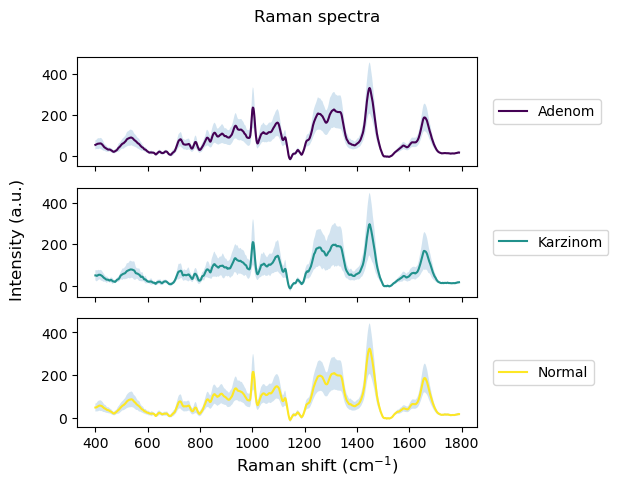

In [11]:
rl.plot.mean_per_group(raw_gsc, "annotation", plot_type="stacked", interval="sd")
plt.show()

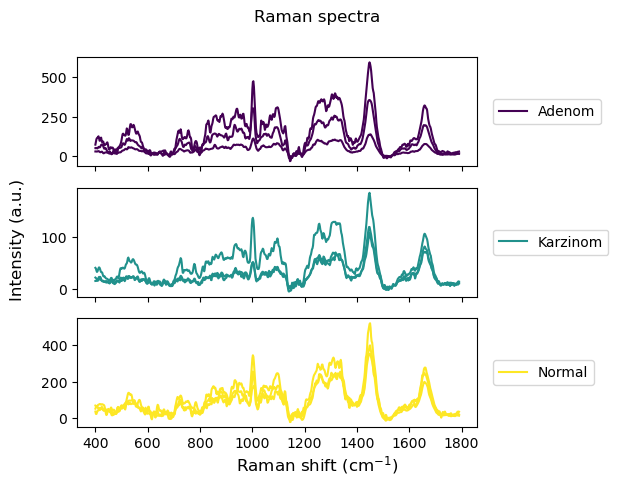

In [12]:
rl.plot.random_per_group(raw_gsc, "annotation", n_samples=3, plot_type="stacked")
plt.show()

In [13]:
len(raw_gsc)

440

In [14]:
# See counts of each annotation
print("Annotation counts:")
print(raw_gsc.df['annotation'].value_counts())

Annotation counts:
annotation
Normal      226
Adenom      153
Karzinom     61
Name: count, dtype: int64


In [15]:
# Check combinations of tissue type, annotation and label
print("Annotation by tissue type:")
print(raw_gsc.df.groupby(['tissue', 'annotation', 'label']).size())

Annotation by tissue type:
tissue       annotation  label
preparation  Adenom      1        153
             Karzinom    1         61
             Normal      0        226
dtype: int64


### Calibrate Raw Spectra

#### Example: Detecting wavenumber shift from internal Si calibration standard

To demonstrate the calibration functions, I will generate hypothetical internal silicon spectral data, which contains a single high-intensity peak. A study conducted by Itoh et al. estimates that the main silicon band is situated at 520.45 ± 0.28 cm-1 for Si 100.

In [16]:
# Generate hypothetical internal silicon standard spectra
from datetime import date

# Parameters
n = 100
ideal_center = 520.45
allowed_halfwidth = 0.28
center_sd = 0.2      # ~few % outside the window
amp_range = (800, 1200)
sigma_range = (0.3, 0.6)
noise_frac = 0.02
seed = 7

rng = np.random.default_rng(seed)

# Wavenumber axis around the Si line
x = np.linspace(480, 560, 1601)

# Random peak parameters
centers = rng.normal(ideal_center, center_sd, size=n)
amps    = rng.uniform(*amp_range, size=n)
sigmas  = rng.uniform(*sigma_range, size=n)

spectra = []
for c, a, s in zip(centers, amps, sigmas):
    y = a * np.exp(-(x - c)**2 / (2 * s**2))
    y += rng.normal(0.0, noise_frac * a, size=x.shape)  # noise
    spectra.append(rp.Spectrum(y, x))

# Minimal fake metadata: rotating dates and 3x3 spots
dates = [date(2025, 8, 1), date(2025, 8, 2)]
spots = [f"({r},{c})" for r in range(1, 4) for c in range(1, 4)]
metadata = [{"date": dates[i % len(dates)], "spot": spots[i % len(spots)]} for i in range(n)]

# Build GroupedSpectralContainer
calib_gsc = rl.GroupedSpectralContainer(spectra, metadata)

Plot randomly selected spectra to visualy verify.

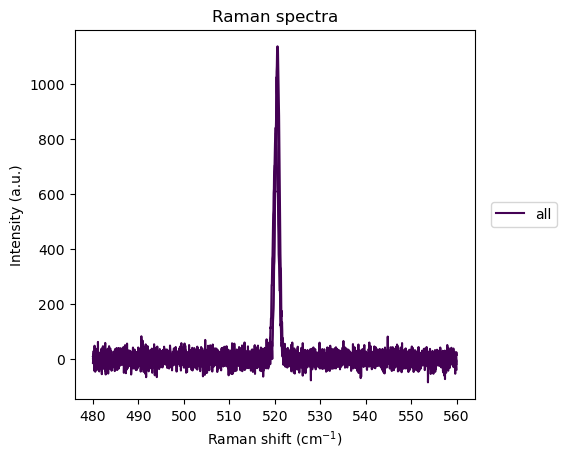

In [17]:
calib_gsc.plot_random(n_samples=3, seed=seed)
plt.show()

Check the calibration of a single spectrum

-0.20040853529962988


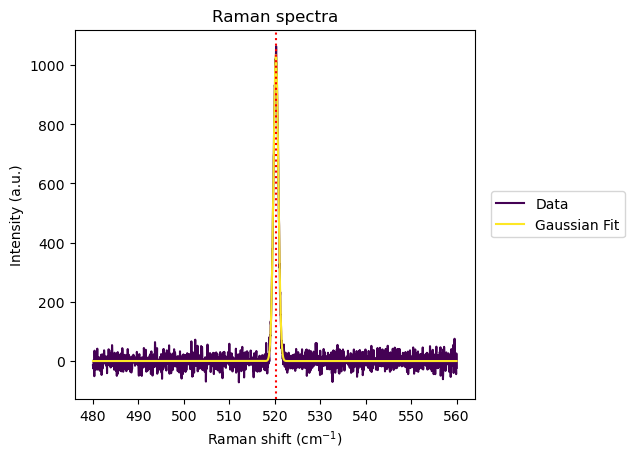

In [18]:
shift_value = rl.calib.get_wn_shift(calib_gsc["spectrum"].iloc[5], 520.45, plot=True)
print(shift_value)
plt.show()

Check the calibration of the entire GSC and return a GSC of uncalibrated spectra

In [19]:
fail_gsc, new_gsc = rl.calib.get_gsc_wn_shifts(
    calib_gsc,
    [520.17, 520.73],
    520.45
)

In [20]:
print(fail_gsc)
print(fail_gsc["shift"].abs().min())
# All shifts in the fail gsc are above 0.28, as expected, since we used the range 520.45 +- 0.28

GroupedSpectralContainer(11 spectra)

                                            spectrum        date   spot  \
0  <ramanspy.core.Spectrum object at 0x7fdcebf41e10>  2025-08-01  (1,1)   
1  <ramanspy.core.Spectrum object at 0x7fdcebf41ed0>  2025-08-01  (1,3)   
2  <ramanspy.core.Spectrum object at 0x7fdcebf40dc0>  2025-08-01  (3,3)   
3  <ramanspy.core.Spectrum object at 0x7fdcebf40c40>  2025-08-01  (2,1)   
4  <ramanspy.core.Spectrum object at 0x7fdcebf40370>  2025-08-02  (1,1)   

       x0_fit     shift  
0  520.069173 -0.380827  
1  520.081641 -0.368359  
2  519.940991 -0.509009  
3  520.144087 -0.305913  
4  520.141240 -0.308760  
0.28534086814056536


In [21]:
print(new_gsc)

GroupedSpectralContainer(100 spectra)

                                            spectrum        date   spot  \
0  <ramanspy.core.Spectrum object at 0x7fdcebf43a90>  2025-08-01  (1,1)   
1  <ramanspy.core.Spectrum object at 0x7fdcebf439a0>  2025-08-02  (1,2)   
2  <ramanspy.core.Spectrum object at 0x7fdcebf43940>  2025-08-01  (1,3)   
3  <ramanspy.core.Spectrum object at 0x7fdcebf42ce0>  2025-08-02  (2,1)   
4  <ramanspy.core.Spectrum object at 0x7fdcebf42c80>  2025-08-01  (2,2)   

       x0_fit     shift  
0  520.447505 -0.002495  
1  520.509446  0.059446  
2  520.396104 -0.053896  
3  520.271215 -0.178785  
4  520.355366 -0.094634  


Using the shift values and dates given in these grouped spectra containers, we are able to apply a wavenumber shift to other data collected on or near the same day.

### Choose Best Baseline Subtraction Algorithm

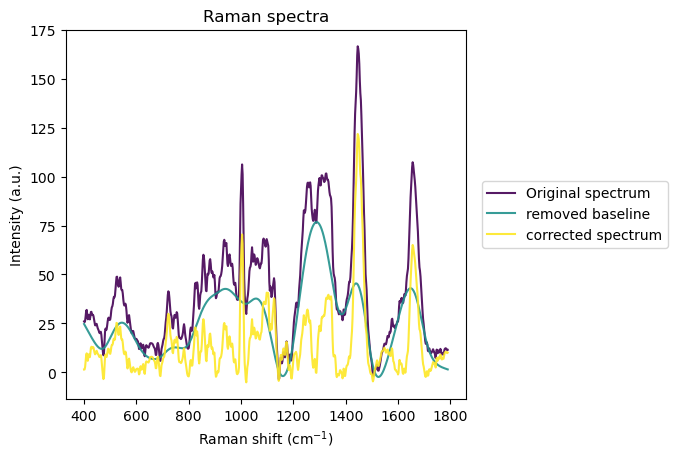

In [22]:
rl.plot.baseline(raw_gsc["spectrum"].iloc[0], rp.preprocessing.baseline.ASLS(lam=1000))
plt.show()

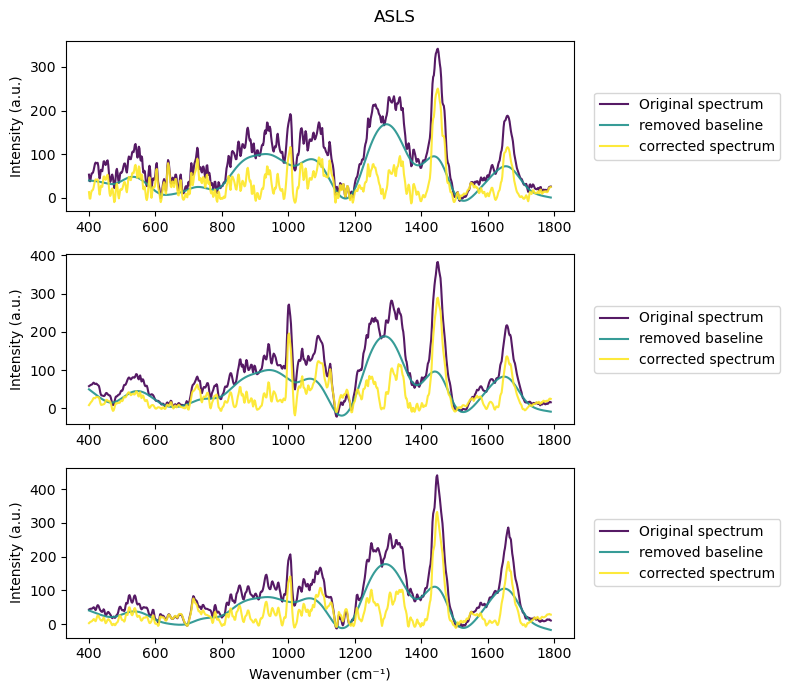

In [23]:
rl.plot.n_baselines(raw_gsc, rp.preprocessing.baseline.ASLS(lam=1000), "ASLS")
plt.show()

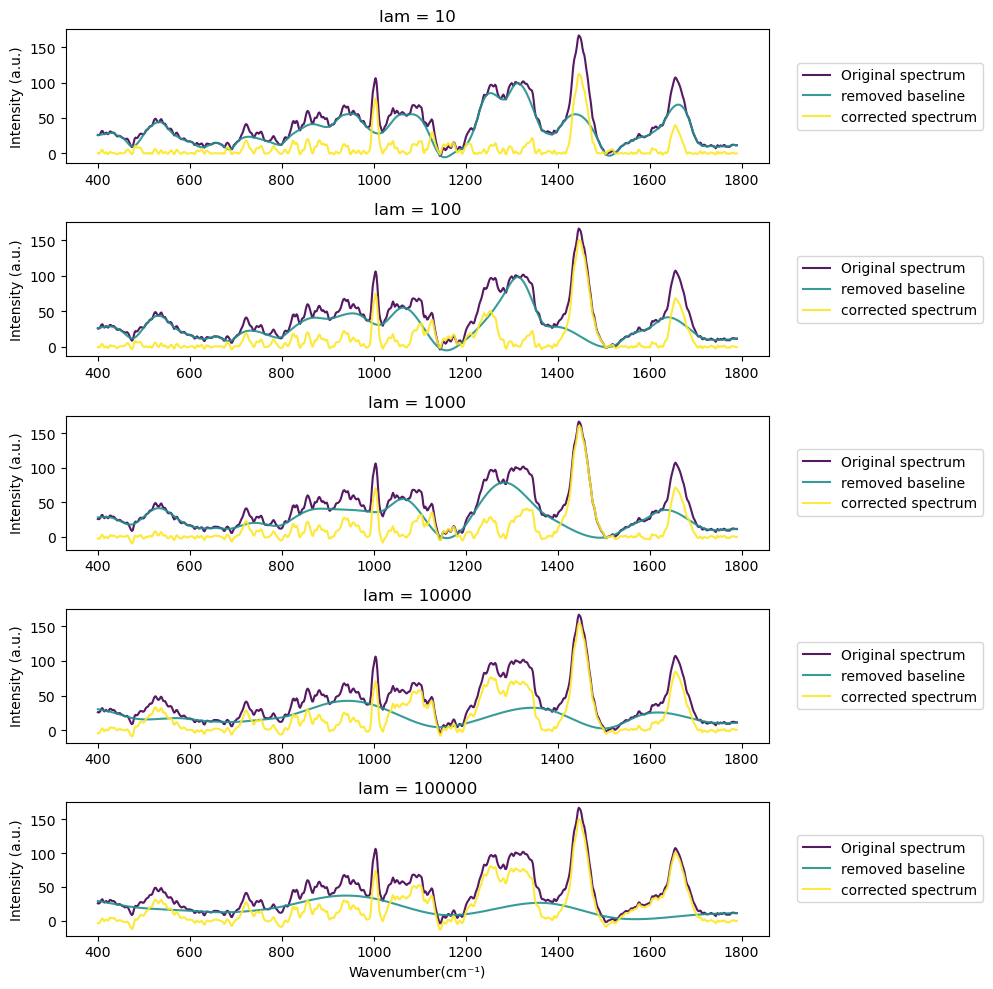

In [24]:
processes = [
    rp.preprocessing.baseline.IARPLS(lam=10),
    rp.preprocessing.baseline.IARPLS(lam=100),
    rp.preprocessing.baseline.IARPLS(lam=1000),
    rp.preprocessing.baseline.IARPLS(lam=10000),
    rp.preprocessing.baseline.IARPLS(lam=100000)
]

names = [
    "lam = 10",
    "lam = 100",
    "lam = 1000",
    "lam = 10000",
    "lam = 100000"
]
rl.plot.compare_baselines(raw_gsc["spectrum"].iloc[0], processes, names, figsize=(10,10))
plt.show()

### Pipeline

In [25]:
# Define the pipeline.
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(lam = 300),
    rp.preprocessing.normalise.MaxIntensity(),
])

In [26]:
prepro_gsc = raw_gsc.apply_pipeline(pipe)

### Visualising Preprocessed Spectra

#### Individual Spectra

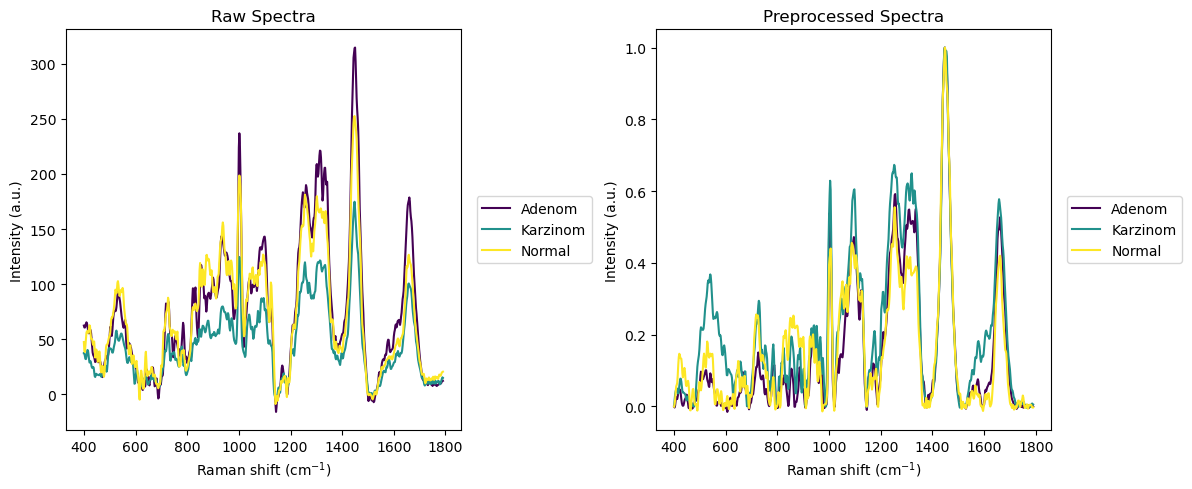

In [27]:
# Plot random spectra before and after preprocessing
# Create 1 row, 2 column subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot randomly selected raw spectra
rl.plot.random_per_group(raw_gsc, by="annotation", plot_type="single", ax=ax1, title="Raw Spectra", n_samples=1)
# Plot randomly selected preprocessed spectra
rl.plot.random_per_group(prepro_gsc, by="annotation", plot_type="single", ax=ax2, title="Preprocessed Spectra", n_samples=1)
plt.tight_layout()
plt.show()

#### Mean Spectra

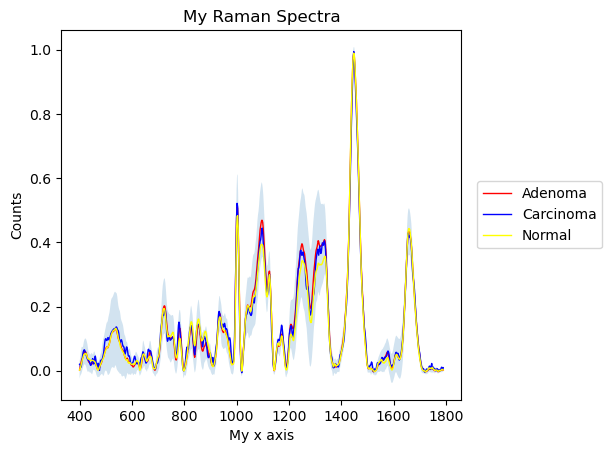

In [28]:
# Demonstrate the full customisability of the plot functions
prepro_gsc.plot_mean(
    by=["annotation", "label"],
    interval="sd",
    plot_type="single",
    linewidth=1,
    label=["Adenoma", "Carcinoma", "Normal"],
    color=["red", "blue", "yellow"],
    title="My Raman Spectra",
    xlabel="My x axis",
    ylabel="Counts"
)
plt.show()                     

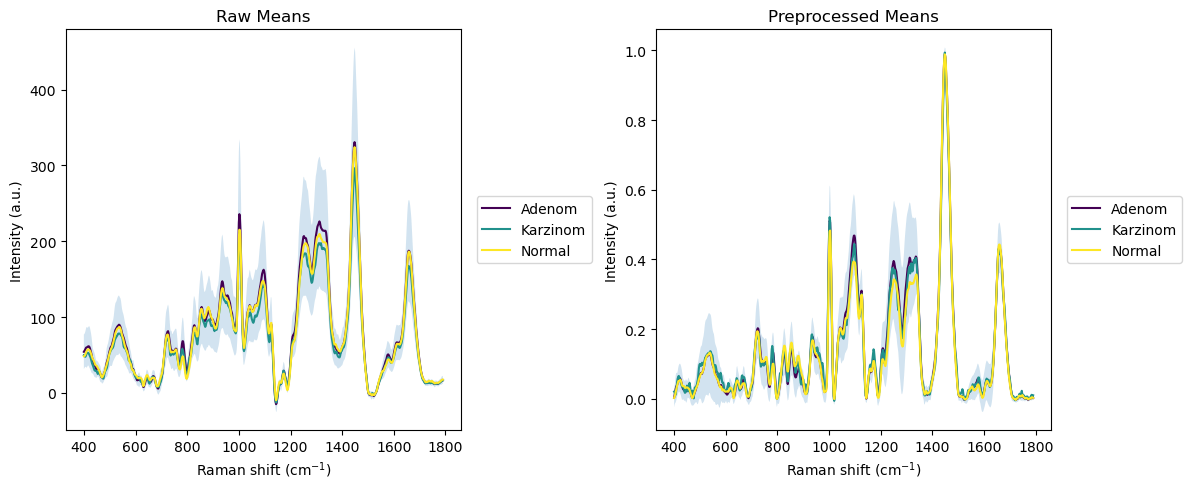

In [29]:
# Plot mean spectra before and after preprocessing
# Create 1 row, 2 column subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot mean spectra before and after preprocessing
rl.plot.mean_per_group(raw_gsc, "annotation", plot_type="single", ax=ax1, title="Raw Means", interval="sd")
rl.plot.mean_per_group(prepro_gsc, "annotation", plot_type="single", ax=ax2, title="Preprocessed Means", interval="sd")
plt.tight_layout()
plt.show()

### Quality Control

In [30]:
results = rl.calc.outliers_per_group(prepro_gsc, rp.metrics.MSE, by="annotation", n_spectra=1)
results

{'Adenom': ([148], <ramanspy.core.Spectrum at 0x7fdcebc91420>),
 'Karzinom': ([69], <ramanspy.core.Spectrum at 0x7fdcebe4c8b0>),
 'Normal': ([393], <ramanspy.core.Spectrum at 0x7fdcebb9f160>)}

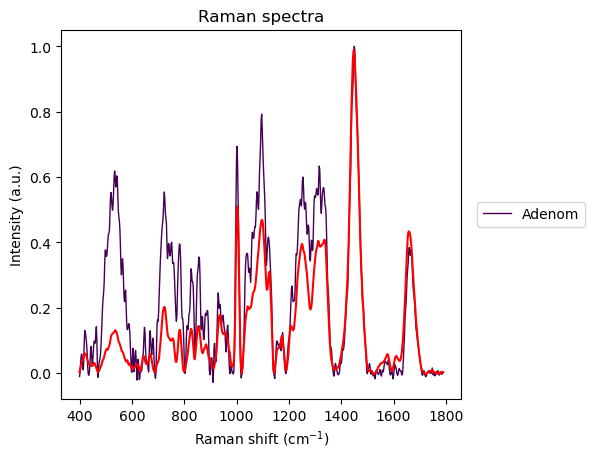

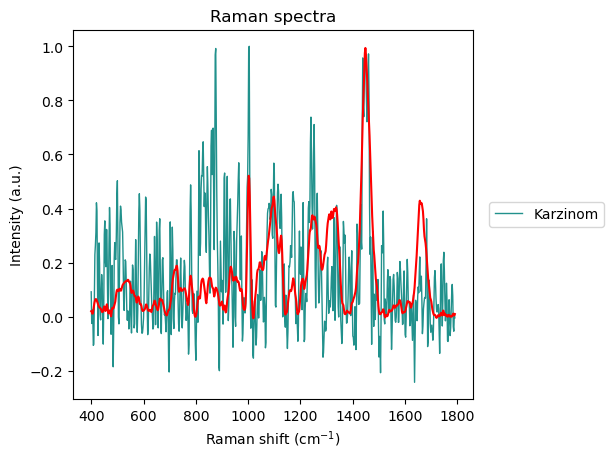

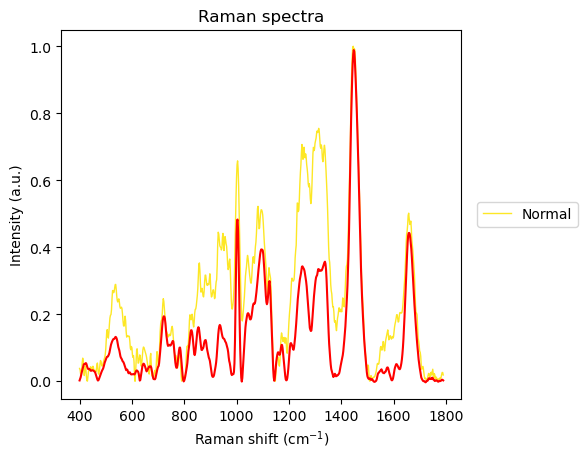

In [31]:
axes = rl.plot.outliers_per_group(prepro_gsc, results, linewidth=1)
plt.show()

The Carcinoma sample at index 69 looks like an error in measurement has made it too noisy, so we will remove it from the dataset.

In [32]:
cleaned_gsc = rl.GroupedSpectralContainer.from_dataframe(prepro_gsc.df.drop(prepro_gsc.df.index[69]))

In [33]:
results = rl.calc.outliers_per_group(cleaned_gsc, rp.metrics.MSE, by="annotation", n_spectra=1)
results

{'Adenom': ([147], <ramanspy.core.Spectrum at 0x7fdcebb9fd30>),
 'Karzinom': ([59], <ramanspy.core.Spectrum at 0x7fdceba7a9e0>),
 'Normal': ([392], <ramanspy.core.Spectrum at 0x7fdcebb9ecb0>)}

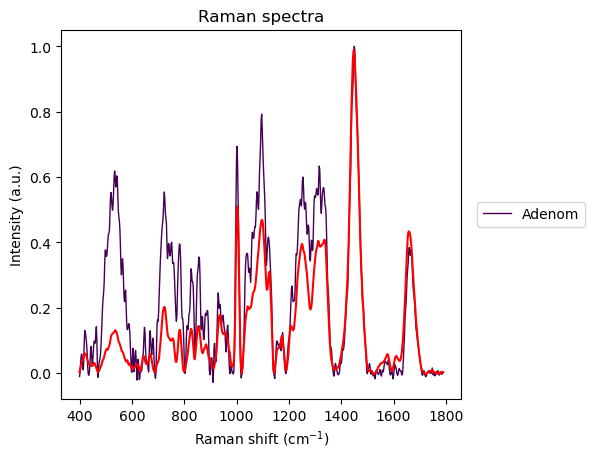

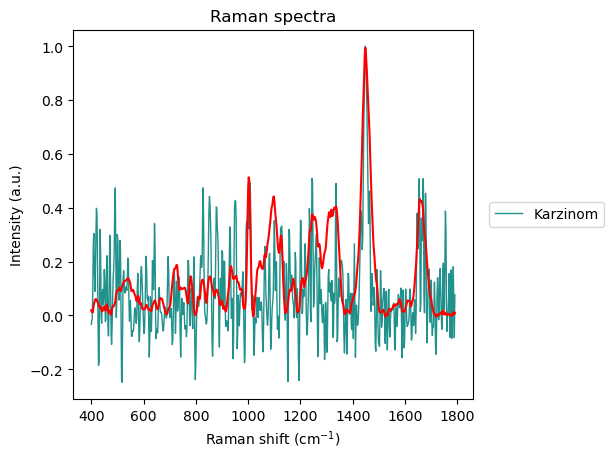

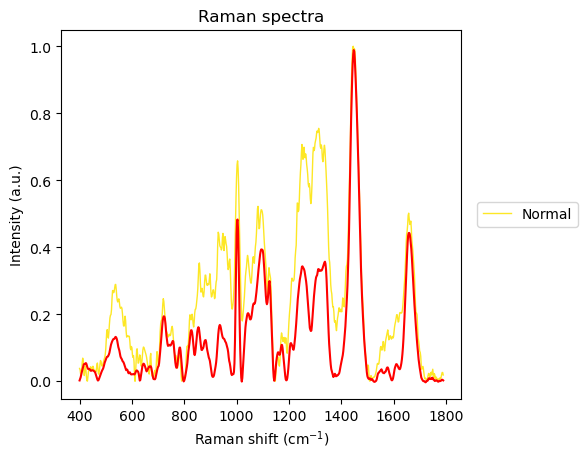

In [34]:
axes = rl.plot.outliers_per_group(cleaned_gsc, results, linewidth=1)
plt.show()

### Between-Group Analysis

#### Difference in Mean Spectra

In [35]:
group_stats = prepro_gsc.mean(by="annotation", include_stats=True)
group1_stats = group_stats[group_stats["annotation"]=="Normal"]
group2_stats = group_stats[group_stats["annotation"]=="Adenom"]
group3_stats = group_stats[group_stats["annotation"]=="Karzinom"]

In [36]:
diff_spectrum_1, ci_band_1 = rl.calc.mean_difference(group1_stats, group2_stats)
diff_spectrum_2, ci_band_2 = rl.calc.mean_difference(group2_stats, group3_stats)
diff_spectrum_3, ci_band_3 = rl.calc.mean_difference(group3_stats, group1_stats)

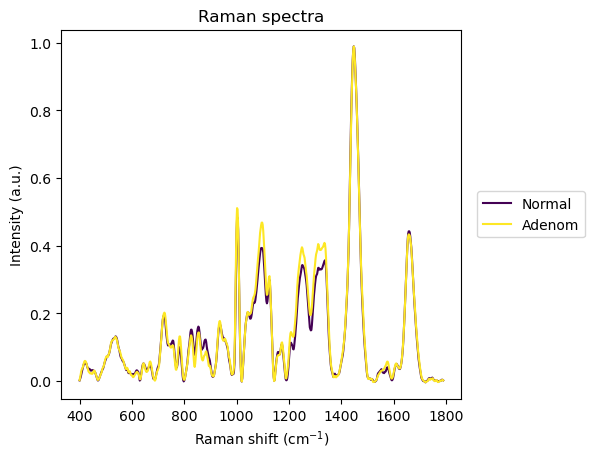

In [37]:
rp.plot.spectra([group1_stats["spectrum"].iloc[0], group2_stats["spectrum"].iloc[0]], plot_type="single", label=["Normal", "Adenom"])
plt.show()

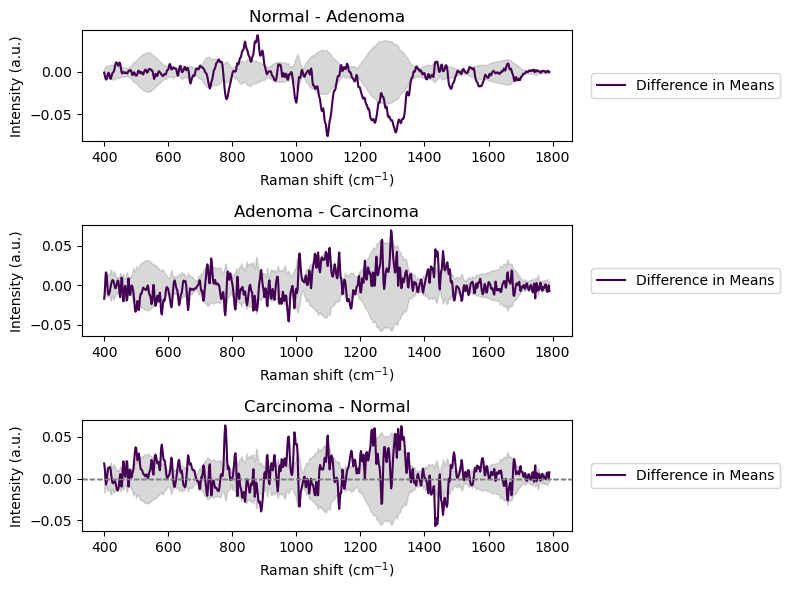

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
rl.plot.mean_difference(diff_spectrum_1, ci_band_1, title="Normal - Adenoma", ax=axs[0])
rl.plot.mean_difference(diff_spectrum_2, ci_band_2, title="Adenoma - Carcinoma", ax=axs[1])
rl.plot.mean_difference(diff_spectrum_3, ci_band_3, title="Carcinoma - Normal", ax=axs[2])
plt.tight_layout()
plt.show()


#### Correlation Coefficient by Annotation

In [39]:
corr = rl.calc.mean_correlation_per_group(prepro_gsc, "annotation")

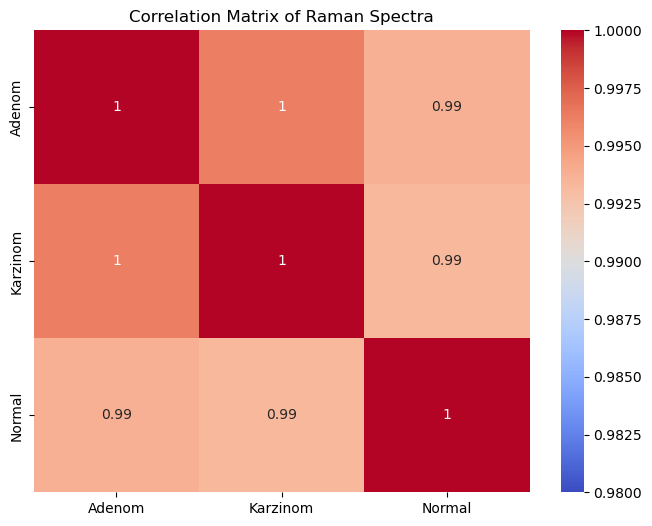

In [40]:
rl.plot.mean_correlation_per_group(corr, vmin=0.98)
plt.show()

#### Correlation Coefficient by Replicate

In [41]:
corr = rl.calc.mean_correlation_per_group(prepro_gsc, "replicate")

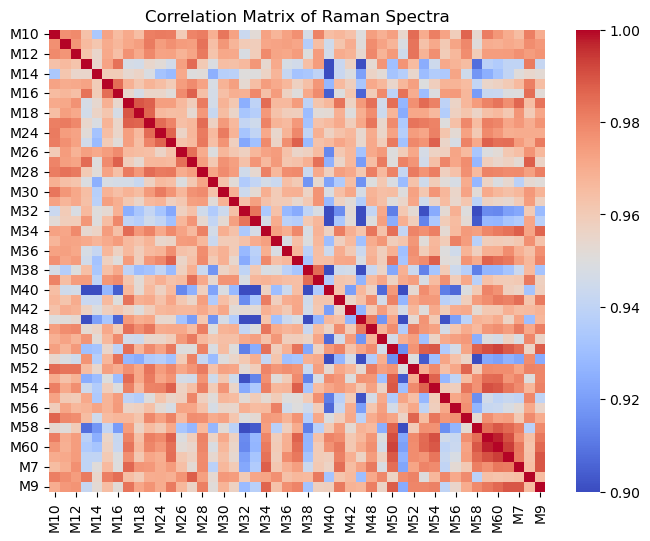

In [42]:
rl.plot.mean_correlation_per_group(corr, annot=False, vmin=0.90, vmax=1.0)
plt.show()

#### Next step: Loading and score plots (Guo et al SOP step 23)

### Classical Least Squares for Spectral Subtraction

In [48]:
import os

# Base directory: folder containing this script
BASE_DIR = os.getcwd()

# Example data folder inside ramanlib
DATA_DIR = os.path.join(BASE_DIR, "CLS_example_data")

# Build relative paths
grating = rp.load.renishaw(os.path.join(DATA_DIR, "grating 10s 50_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))
water = rp.load.renishaw(os.path.join(DATA_DIR, "water 10s 10_ 3acc 532nm 1200lmm extended range 200-3600 spot 3.wdf"))
ethanol = rp.load.renishaw(os.path.join(DATA_DIR, "ethanol 10s 1_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))
water_and_ethanol = rp.load.renishaw(os.path.join(DATA_DIR, "water and ethanol 10s 10_ 3acc 532nm 1200lmm extended range 200-3600 spot 1.wdf"))

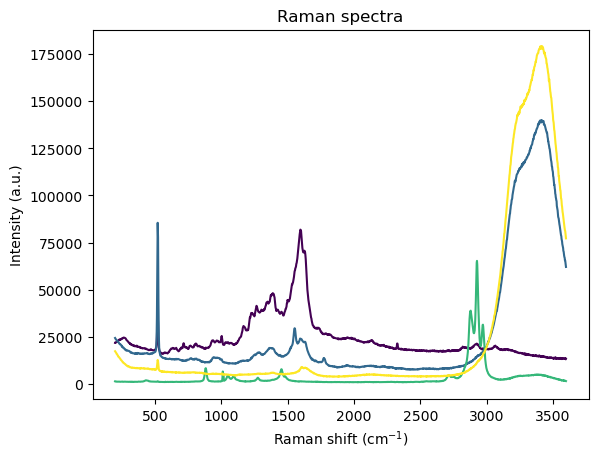

In [49]:
rp.plot.spectra([grating, water, ethanol, water_and_ethanol], plot_type="single")
plt.show()

In [45]:
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(lam = 3000),
    rp.preprocessing.normalise.MaxIntensity(),
])

grating_prepro = pipe.apply(grating)
water_prepro = pipe.apply(water)
ethanol_prepro = pipe.apply(ethanol)
water_and_ethanol_prepro = pipe.apply(water_and_ethanol)

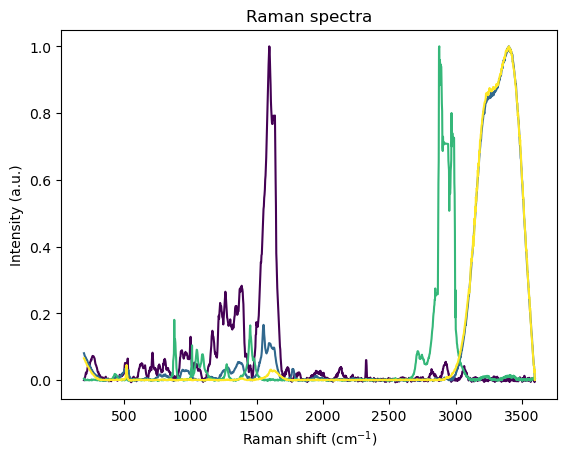

In [46]:
rp.plot.spectra([grating_prepro, water_prepro, ethanol_prepro, water_and_ethanol_prepro], plot_type="single")
plt.show()

components:
grating, -0.11092895269393921
water, 1.0101244449615479
ethanol, 0.012555450201034546


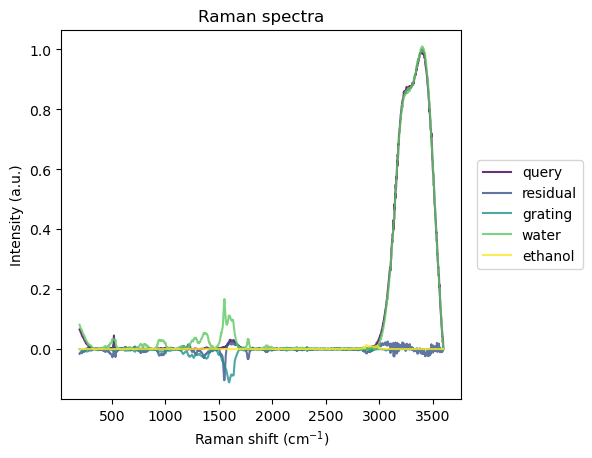

In [47]:
cs, res_spec, fitted_components_spec = rl.analysis.CLS(water_and_ethanol_prepro, [grating_prepro, water_prepro, ethanol_prepro], ["grating", "water", "ethanol"])
plt.show()